In [268]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import dataLoader as dl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import util as ut

#from Inner_Speech_Dataset.Plotting.ERPs import 
from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Calculate_power_windowed
from Inner_Speech_Dataset.Python_Processing.Utilitys import picks_from_channels
from Inner_Speech_Dataset.Python_Processing.Data_processing import Average_in_frec

In [269]:


sampling_rate = 256
nr_of_datasets=1
data, labels = dl.load_multiple_datasets(nr_of_datasets=nr_of_datasets, sampling_rate=sampling_rate, t_min=2, t_max=3, twoDLabels=False)

ch_names = ut.get_channelNames()

print(data.shape)
data_p =  ut.get_power_array(data[:,:128,:], sampling_rate, trialSplit=1).squeeze()
print(data_p.shape)
#print(data_p[:,:,1])

#Getting Freq Data 
nr_of_buckets = 15
buckets = ut.createFreqBuckets(data[:,:128,:], nr_of_buckets)

#buckets = np.reshape(np.linspace(0,50,nr_of_buckets*2),[nr_of_buckets, -1])
#buckets = np.array([[0,3],[4,8],[9,15],[16,34],[35,45],[45,80]])
nr_of_buckets = buckets.shape[0]
print("buckets")
print(buckets)
data_f = ut.data_into_freq_buckets(data[:,:128,:], nr_of_buckets, buckets)
#data_f = np.concatenate([dataf, np.zeros([data_f.shape[0], nr_of_datasets, data_f.shape[2]])], axis=1)

print(data_f.shape)


## Normalize data



Data shape: [trials x channels x samples]
(500, 128, 256)
Labels shape
(500, 4)
Final data shape
(100, 128, 256)
Final labels shape
(100,)
Up is 0.0 and Down is 1.0
(100, 128, 256)
(100, 128, 2)
buckets
[[  0   2]
 [  2   5]
 [  5   8]
 [  8  12]
 [ 12  16]
 [ 16  21]
 [ 21  28]
 [ 28  36]
 [ 36  47]
 [ 47  60]
 [ 60  77]
 [ 76  94]
 [ 91 112]
 [ 67  79]
 [  3   4]]
(100, 128, 15)


In [270]:
# from scipy.signal import welch
# print(data.shape)
# wd = welch(data[2,2], fs=256, nperseg=None)
# print(wd[1].shape)

from scipy import ndimage
gd = ndimage.gaussian_filter1d(data[2,2], 5)
gd = ndimage.gaussian_filter1d(data, 1, axis=2)


(100, 128, 128)
(100, 128, 128)
(100, 128, 128)
(100, 128, 128)
(100, 128, 128)
(100, 128, 128)


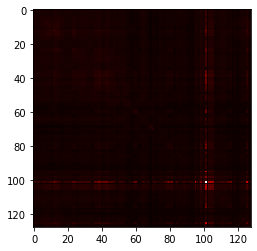

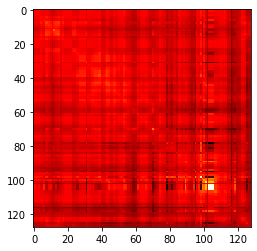

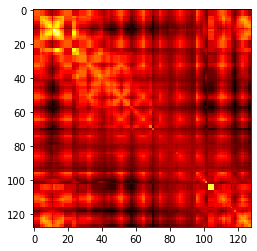

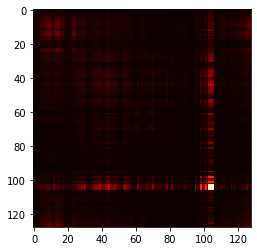

In [271]:
from scipy.fft import rfft, ifft, fftshift, fftfreq
#fftfreq(data.shape[2],1/data.shape[2])
import seaborn as sn
import scipy as sc
from scipy import ndimage

#Make FFT data
fftdata = ut.fftData(data)
print(fftdata.shape)

#Make Welch data
welchdata = ut.welchData(data, fs=256, nperseg=256)
print(welchdata.shape)

#Make covariance of FFT data
dataFFTCV = np.array(ut.fftCovariance(fftdata))
print(dataFFTCV.shape)

#Make covariance of welch data
dataWCV = np.array(ut.fftCovariance(welchdata))
print(dataWCV.shape)

#Make covariance of non fft data
datagauss = ndimage.gaussian_filter1d(data, 5, axis=2)
dataCV = np.array(ut.fftCovariance(datagauss))
print(dataCV.shape)

#Make covariance of non fft data
datagauss = ndimage.gaussian_filter1d(data, 2, axis=2, order=1)
dataCV2 = np.array(ut.fftCovariance(datagauss))
print(dataCV2.shape)

#Welch FFT similar. PSD 
#Try to remove noise

#Plot heatmaps 
plt.figure()
plt.imshow(dataFFTCV[2], cmap="hot", interpolation="nearest")
plt.show()
plt.figure()
plt.imshow(dataCV[2], cmap="hot", interpolation="nearest")
plt.show()

plt.figure()
plt.imshow(dataCV2[2], cmap="hot", interpolation="nearest")
plt.show()
plt.figure()
plt.imshow(dataWCV[2], cmap="hot", interpolation="nearest")
plt.show()

In [272]:
#from scipy.fft import rfft, ifft, fftshift, fftfreq
#fftfreq(data.shape[2],1/data.shape[2])

print(len(np.where(dataFFTCV==0)[1]))

0


In [273]:
print(data_f.shape)
print(data_p.shape)
print(labels.shape)
print(data_p[2,5])

#data = np.concatenate([data_f, data_p], axis =2 ) #, data
data = np.concatenate([dataWCV, dataCV], axis =1 ) #, data
#data = dataWCV
#data = dataCV2
#data = dataWCV
#Data FFTCV seems useless!
#data = dataFFTCV #, data

print(data.shape)
data = keras.utils.normalize(data, axis=1, order=2)
print(data.shape)
#print(data[2,5])
#print(labels[2])
print(labels[:].shape)

(100, 128, 15)
(100, 128, 2)
(100,)
[9.56732240e-11 4.90024352e-11]
(100, 256, 128)
(100, 256, 128)
(100,)


In [274]:
#Add end of ekg with specific array for each person. 


In [275]:
#Splitting into training and test data
#print(labels)


order = np.arange(labels.shape[0])
np.random.shuffle(order)

temp_data = np.zeros(data.shape)
temp_labels = np.zeros(labels.shape)

for x in range(labels.shape[0]):
    i = order[x]
    
    temp_data[x] = data[i]
    temp_labels[x] = labels[i]

data = temp_data
labels = temp_labels

data_train, data_test = np.split(data, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
labels_train, labels_test = np.split(labels, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
print(labels_train.shape)
print(data_train.shape)
print(data_test.shape)




(75,)
(75, 256, 128)
(25, 256, 128)


In [276]:
#!pip3 install sklearn -q
from tabnanny import verbose
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report

def svmPipeline(data_train, data_test, labels_train,
    labels_test, kernel="linear", degree=3, gamma="auto", C = 1
    , coefs = np.zeros([1, data_train.shape[1] * data_train.shape[2]])): 
    
    anova_filter = SelectKBest(f_classif, k=10)
    clf = make_pipeline( StandardScaler() ,  SVC( #anova_filter/#,
        gamma=gamma, kernel=kernel, degree=degree, verbose=False, C=C))

    clf.fit(np.reshape(data_train, [data_train.shape[0], -1]), labels_train)
    predictions = clf.predict(np.reshape(data_test, [data_test.shape[0], -1]))
    
    print(classification_report(labels_test, predictions))
    if kernel == "linear":
        coefs = coefs + clf[:-1].inverse_transform(clf[-1].coef_)
    #print(clf[:-1].inverse_transform(clf[-1].coef_).shape)

    correct = np.zeros(labels_test.shape)
    correctamount=0
    for nr, pred in enumerate(predictions,0):
        if pred == labels_test[nr]:
            correct[nr] = 1
            correctamount +=1


    return correctamount/labels_test.shape[0], coefs

#testing using different kernels, C and degrees. 
coefs = np.zeros([1, data_train.shape[1] *data_train.shape[2]]) #
for kernel in ["linear", "rbf", "sigmoid"]:

    for C in np.linspace(0.2,1,5):
    
        if kernel == "linear":
            for degree in range(2,3):
                res, coefs = svmPipeline(data_train, data_test, labels_train, 
                labels_test, degree=degree, kernel = kernel, C = C, coefs=coefs)
                print("Result for degree {}, kernel {}, C = {}: {}".format(degree, kernel, C,  res))
        # else:
        #     for gamma in ["auto", "scale"]:

        #         res = svmPipeline(data_train, data_test, labels_train, 
        #         labels_test, degree=degree, kernel = kernel, gamma=gamma, C = C)
        #         print("Result for gamma {}, kernel {}, C = {}: {}".format(gamma, kernel, C, res))

coefs = np.reshape(coefs, [128,-1])

              precision    recall  f1-score   support

         0.0       0.60      0.82      0.69        11
         1.0       0.80      0.57      0.67        14

    accuracy                           0.68        25
   macro avg       0.70      0.69      0.68        25
weighted avg       0.71      0.68      0.68        25

Result for degree 2, kernel linear, C = 0.2: 0.68
              precision    recall  f1-score   support

         0.0       0.60      0.82      0.69        11
         1.0       0.80      0.57      0.67        14

    accuracy                           0.68        25
   macro avg       0.70      0.69      0.68        25
weighted avg       0.71      0.68      0.68        25

Result for degree 2, kernel linear, C = 0.4: 0.68
              precision    recall  f1-score   support

         0.0       0.60      0.82      0.69        11
         1.0       0.80      0.57      0.67        14

    accuracy                           0.68        25
   macro avg       0.70     

In [277]:
#Checks which frequency buckets are most valuable
def coefFeatureCheck(coefs, buckets):
    for x in range(buckets.shape[0], buckets.shape[0] + 2):
        print("Power feature bin {} has value {} ".format(x-buckets.shape[0], np.sum(coefs[:,x])))

    freqBins = np.zeros(buckets.shape[0])
    for x in range(0,buckets.shape[0]):
        #print(np.sum(coefs[:,0]))
        freqBins [x] = np.sum(coefs[:,x])
        print("Frequency bin {} has feature value of {}".format(buckets[x], np.sum(coefs[:,x])))

    channelBins = np.zeros(coefs.shape[0])
    for x in range(0, coefs.shape[0]):
        #print(np.sum(coefs[:,0]))
        if  np.sum(coefs[x,:]) == 0:
            continue
        channelBins[x] = np.sum(coefs[x,:])
        print("Channel bin {} has feature value of {}".format(x, np.sum(coefs[x,:])))

    #print(channelBins)
    #print(freqBins)
    print(buckets[np.argpartition(freqBins, -4)[-4:]])
    return np.argpartition(freqBins, -4)[-4:]
mostUsefulFreqBuckets =  coefFeatureCheck(coefs, buckets)
print(mostUsefulFreqBuckets)



Power feature bin 0 has value 22.89918035073755 
Power feature bin 1 has value 23.62062737666051 
Frequency bin [0 2] has feature value of 25.560199956489033
Frequency bin [2 5] has feature value of 25.540842842069843
Frequency bin [5 8] has feature value of 25.557986528106582
Frequency bin [ 8 12] has feature value of 25.547652923067993
Frequency bin [12 16] has feature value of 24.493978754367077
Frequency bin [16 21] has feature value of 24.99930417461072
Frequency bin [21 28] has feature value of 24.514598430440017
Frequency bin [28 36] has feature value of 23.15970274289596
Frequency bin [36 47] has feature value of 23.1617824639048
Frequency bin [47 60] has feature value of 20.94013088128427
Frequency bin [60 77] has feature value of 19.04337049328533
Frequency bin [76 94] has feature value of 14.574515296914983
Frequency bin [ 91 112] has feature value of 16.273898250855265
Frequency bin [67 79] has feature value of 18.590214136158874
Frequency bin [3 4] has feature value of 20.

In [278]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()





eeg_model = tf.keras.Sequential([

    layers.LocallyConnected1D(20, input_shape = (data_train.shape[1],data_train.shape[2]), 
     kernel_size=15, 
     padding="valid", strides=8,
     activation="relu"),
    
    
    layers.LocallyConnected1D(20, 
    kernel_size=15, 
    padding="valid", strides=5,
    activation="relu"),
    
    layers.Dropout(0.8),
    
    layers.Dense(units=200, activation="relu"),
    
    layers.Dropout(0.8),

    layers.Flatten(),

    layers.Dense(units=2, activation="softmax")


])
eeg_model.build()
eeg_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected1d (Locall  (None, 31, 20)           1191020   
 yConnected1D)                                                   
                                                                 
 locally_connected1d_1 (Loca  (None, 4, 20)            24080     
 llyConnected1D)                                                 
                                                                 
 dropout (Dropout)           (None, 4, 20)             0         
                                                                 
 dense (Dense)               (None, 4, 200)            4200      
                                                                 
 dropout_1 (Dropout)         (None, 4, 200)            0         
                                                                 
 flatten (Flatten)           (None, 800)               0

In [279]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
#callback2 = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=2)

eeg_model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

data_train_send = np.reshape(data_train, [data_train.shape[0], 1 , data_train.shape[1], data_train.shape[2], 1])
#data_train_send = np.reshape(data_train, [data_train.shape[0], 1 , data_train.shape[1], data_train.shape[2], 1])

data_test_send = np.reshape(data_test, [data_test.shape[0], 1 , data_test.shape[1], data_test.shape[2], 1])
#data_test_send = np.reshape(data_test, [data_test.shape[0], 1 , data_test.shape[1], data_test.shape[2], 1])

outputs = eeg_model.fit(data_train, labels_train, validation_split=0.2 ,callbacks=[callback], epochs=50) #

print("Results")
eeg_model.evaluate(data_test, labels_test)
result = eeg_model.predict(data_test)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\Luna\anaconda3\envs\ForMasterBelgium\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).


In [ ]:

eeg_model.save('saved_model/my_model6')

INFO:tensorflow:Assets written to: saved_model/my_model6\assets


In [ ]:
print("Results")
eeg_model.evaluate(data_test, labels_test)
result = eeg_model.predict(data_test)

result2 = []
print(result)
for res in result:
    x = np.maximum(res[0], res[1])
    result2.append(int(np.where(res == x)[0]))

result2 = np.array(result2)
print(result2)

Results
1/1 [==============================] - 0s 19ms/step
[[7.2694892e-01 2.7305105e-01]
 [3.8849583e-01 6.1150414e-01]
 [2.3448229e-02 9.7655177e-01]
 [1.0121168e-02 9.8987877e-01]
 [6.9411544e-05 9.9993062e-01]
 [1.4454442e-01 8.5545564e-01]
 [1.3466945e-02 9.8653305e-01]
 [7.4755740e-01 2.5244254e-01]
 [7.5335383e-02 9.2466462e-01]
 [8.3851330e-02 9.1614866e-01]
 [7.8725910e-01 2.1274088e-01]
 [2.0782053e-01 7.9217941e-01]
 [1.4555229e-02 9.8544472e-01]
 [5.3242538e-02 9.4675744e-01]
 [6.2527745e-03 9.9374723e-01]
 [5.6260753e-01 4.3739250e-01]
 [7.4348336e-01 2.5651667e-01]
 [7.6414049e-01 2.3585953e-01]
 [4.1789272e-01 5.8210737e-01]
 [3.9263193e-02 9.6073681e-01]
 [6.0369277e-01 3.9630726e-01]
 [7.6168078e-01 2.3831928e-01]
 [1.8715034e-01 8.1284964e-01]
 [4.8335150e-02 9.5166487e-01]
 [1.1280457e-01 8.8719541e-01]]
[0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1]
